# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Основные шаги:

1. Загрузить данные.
2. Изучить данные. Заполнить пропущенные значения и обработайть аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
3. Подготовить выборки для обучения моделей.
4. Обучить разные модели.
5. Проанализировать время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке.

## Подготовка данных

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.dummy import DummyRegressor
from sklearn.compose import make_column_transformer

from lightgbm import LGBMRegressor




In [14]:
path = "datasets/autos.csv"
if os.path.exists(path):
    data = pd.read_csv(path)
else:
    print('Что-то пошло не так')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [16]:
data_shape0 = data.shape[0]

In [17]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [18]:
data = data.rename(columns={'DateCrawled': 'date_crawled', 'VehicleType': 'vehicle_type', 
                            'RegistrationMonth':'registration_month', 'FuelType':'fuel_type',
                           'DateCreated':'date_created', 'NumberOfPictures':'number_of_pictures',
                           'PostalCode':'postal_code', 'LastSeen':'last_seen', 'RegistrationYear':'registration_year'})

In [19]:
data.columns = [column.lower() for column in data.columns]

In [20]:
data.isna().sum()# число пропущенных значений

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [21]:
data.duplicated().sum() # число дубликатов

4

In [22]:
data_date_created = data['date_created']

In [23]:
data = data.drop(columns=['date_crawled','date_created', 'postal_code', 'number_of_pictures', 'last_seen'])

In [24]:
data['vehicle_type'].unique(), data['fuel_type'].unique(), data['gearbox'].unique(),\
data['model'].unique(), data['brand'].unique()

(array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
        'wagon', 'other'], dtype=object),
 array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
        'electric'], dtype=object),
 array(['manual', 'auto', nan], dtype=object),
 array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
        '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
        'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
        'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
        'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
        'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
        'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
        'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
        '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
        'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', '

In [25]:
data[['vehicle_type', 'fuel_type', 'model']] = data[['vehicle_type', 'fuel_type', 'model']].fillna('other')


In [26]:
np.random.seed(1234)
data['repaired'] = data['repaired'].fillna(pd.Series(np.random.randint(0, 2, size=len(data)), index=data.index))# заполенение случайными значениями
data['repaired'] = data['repaired'].replace(['yes', 'no'],[1, 0]) # заполняем пропуски в столбеце случайными значениями

In [27]:
np.random.seed(12345)
random_int = np.random.randint(0, 2, size=len(data))
data['gearbox'] = data['gearbox'].fillna(pd.Series([['manual', 'auto'][i] for i in random_int] , index=data.index))# заполенение случайными значениями 

In [28]:
data.isna().sum().sum()# суммарное число пропусков

0

In [29]:
# le = LabelEncoder()
# code_columns = ['model', 'brand', 'vehicle_type', 'fuel_type', 'gearbox']
# data[code_columns] = data[code_columns].apply(lambda col: le.fit_transform(col)) #кодировка code_columns при помощи LabelEncoder

In [30]:
data.info()# информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        354369 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             354369 non-null  object
 4   power               354369 non-null  int64 
 5   model               354369 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           354369 non-null  object
 9   brand               354369 non-null  object
 10  repaired            354369 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 29.7+ MB


In [32]:
numeric = ['price', 'registration_year', 'power',
       'registration_month'] # переведем kilometer в категориальные признаки 
data[numeric].describe()# информация о столбцах numeric

,price,registration_year,power,registration_month
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,5.714645
std,4514.158514,90.227958,189.850405,3.726421
min,0.000000,1000.000000,0.000000,0.000000
25%,1050.000000,1999.000000,69.000000,3.000000
50%,2700.000000,2003.000000,105.000000,6.000000
75%,6400.000000,2008.000000,143.000000,9.000000
max,20000.000000,9999.000000,20000.000000,12.000000


In [33]:
data.isna().sum().sum()# число пропущенных значений

0

In [34]:
data['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000], dtype=int64)

In [35]:
data_date_created = pd.to_datetime(data_date_created, format='%Y-%m-%d %H:%M:%S')

In [36]:
data_cut = data.loc[data['registration_year']<= data_date_created.dt.year]

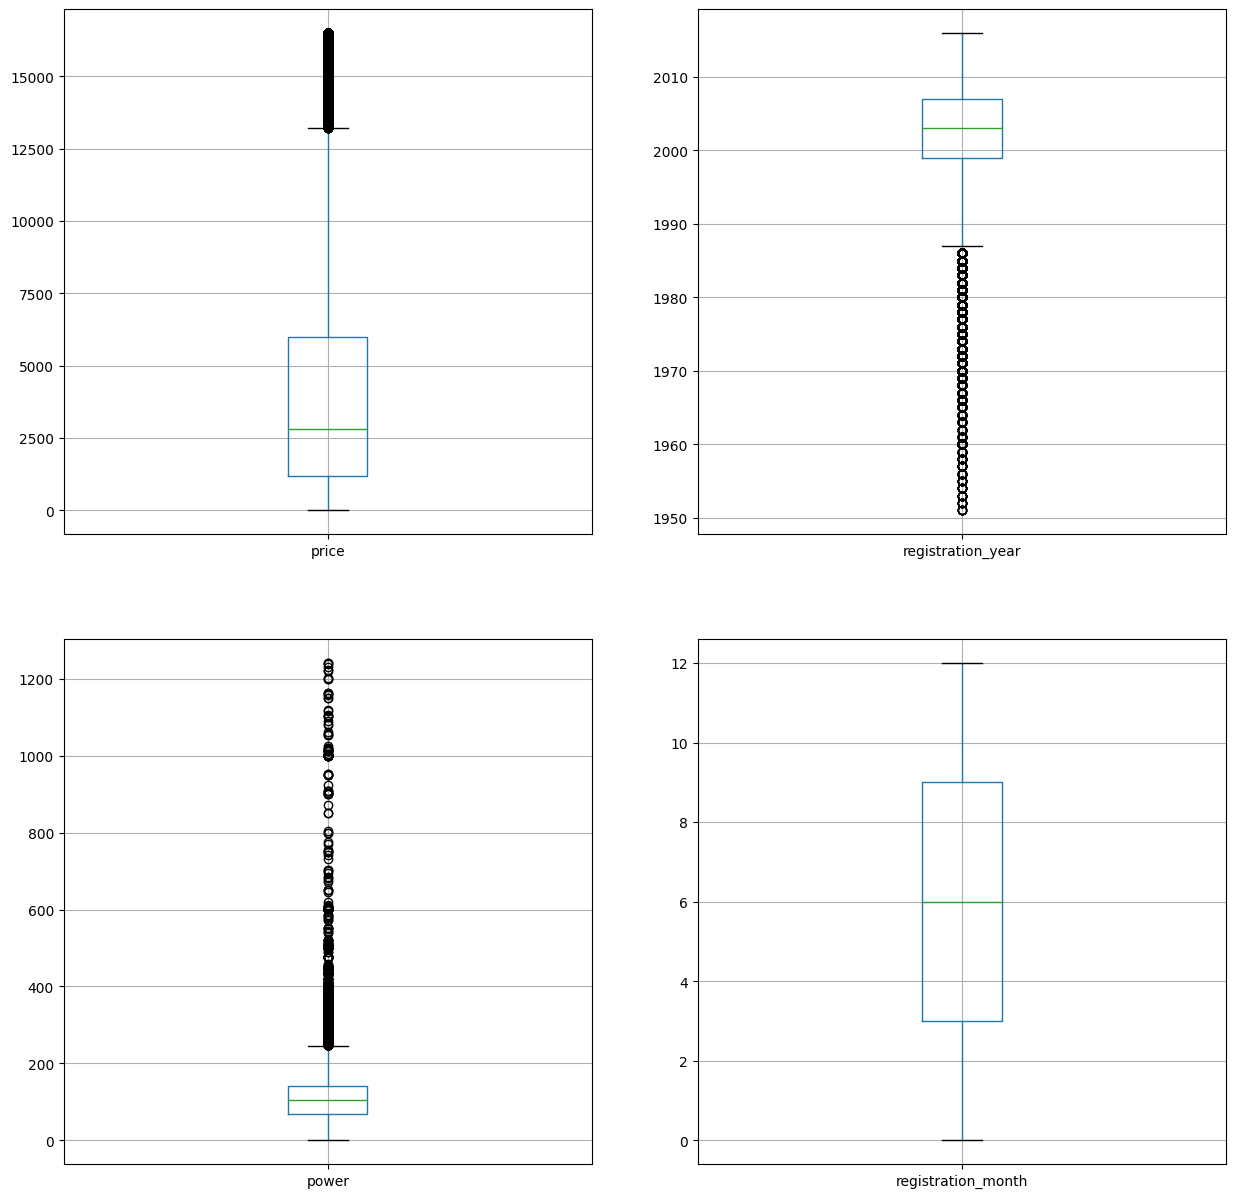

In [99]:
fig = plt.figure(figsize=(15,15))
for i, name in enumerate(numeric): # boxplot для колонок из numeric
    plt.subplot(2, 2, i+1)
    data_cut[[name]].boxplot();

In [38]:
data_cut = data_cut.query('0 < price< 16500 and power < 1250 and registration_year > 1950')# удаляем часть выбросов

In [39]:
data_cut.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319155 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               319155 non-null  int64 
 1   vehicle_type        319155 non-null  object
 2   registration_year   319155 non-null  int64 
 3   gearbox             319155 non-null  object
 4   power               319155 non-null  int64 
 5   model               319155 non-null  object
 6   kilometer           319155 non-null  int64 
 7   registration_month  319155 non-null  int64 
 8   fuel_type           319155 non-null  object
 9   brand               319155 non-null  object
 10  repaired            319155 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 29.2+ MB


In [40]:
1 - data_cut.shape[0]/data_shape0 # доля потерь

0.09937099464117916

C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\victo\anaconda3\envs\working\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

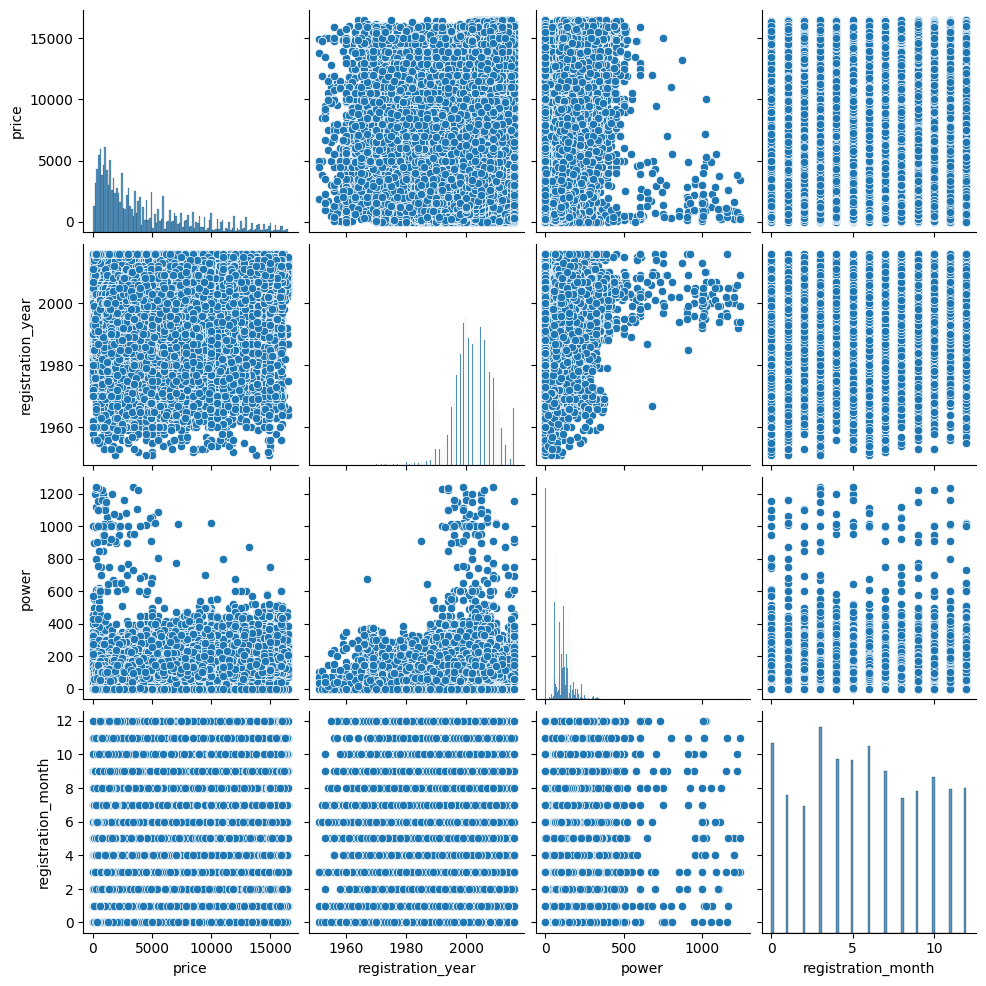

In [67]:
sns.pairplot(data_cut[numeric]);

In [42]:
data_cut[numeric].corr()

,price,registration_year,power,registration_month
price,1.000000,0.447703,0.453077,0.098260
registration_year,0.447703,1.000000,0.128173,0.063408
power,0.453077,0.128173,1.000000,0.109332
registration_month,0.098260,0.063408,0.109332,1.000000


1. Теоретически некоторые данные могут совпадать, поэтому удалять дубликаты не требуется.
2. Удалим столбцы, которые не нужны для предсказания стоимости автомобиля. 
3. Заполним пропущенные значения в столбце `repaired` случайными значениями 0 или 1 и заменим строки *yes* и *no* на 1 и 0 соответственно.  Пропущенные значения в столбце `gearbox` заменим в случайном порядке строками *manual* или *auto*. Пропущенные значения в столбцах `vehicle_type`, `fuel_type` и `model` отнесем к категории *other*. 
4. Удалили выбросы, доля потерь не превышает 10%.
5. Распределения численных признаков схожи с распределением Пуассона, наибольшая корреляция для численных признаков наблюдается между ценой и годом регистрации, ценой и мощностью автомобиля.

## Обучение моделей

### Разделение и подготовка выборок 

In [43]:
features = data_cut.drop(['price'], axis=1)
target = data_cut['price']

In [44]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)# отделяем 80% данных для обучающей и валидацианной выборки


In [45]:
print(features_train_valid.shape)
print(features_test.shape)
print(target_train_valid.shape)
print(target_test.shape)

(255324, 10)
(63831, 10)
(255324,)
(63831,)


In [46]:
numeric_features = numeric[1:]

scaler = StandardScaler() 
scaler.fit(features_train_valid[numeric_features])

features_train_valid_tmp = features_train_valid.copy().reset_index(drop=True)
features_train_valid_tmp.loc[:, numeric_features] = scaler.transform(features_train_valid[numeric_features]) # масштабирование
features_test_tmp = features_test.copy().reset_index(drop=True)
features_test_tmp.loc[:, numeric_features] = scaler.transform(features_test[numeric_features])


In [47]:
le = LabelEncoder()#unknown_value=-1
code_columns = ['model', 'brand', 'vehicle_type', 'fuel_type', 'gearbox', 'kilometer'] # добавил kilometer


features_train_valid_labeled = features_train_valid_tmp.copy()
features_test_labeled = features_test_tmp.copy()

for col in code_columns:
    le.fit(features_train_valid_tmp[col])
    features_train_valid_labeled[col] = le.transform(features_train_valid_tmp[col]) # масштабирование
    features_test_labeled[col] = le.transform(features_test_tmp[col])

In [48]:
ohe = OneHotEncoder(drop = 'first') # кодируем категориальные данные с помощью OHE
ohe.fit(features_train_valid_labeled[code_columns[1:]])

array_hot_encoded_train_valid = ohe.transform(features_train_valid_labeled[code_columns[1:]]).toarray()
array_hot_encoded_test = ohe.transform(features_test_labeled[code_columns[1:]]).toarray()

data_hot_encoded_train_valid = pd.DataFrame(array_hot_encoded_train_valid, index=features_train_valid_labeled.index)
data_hot_encoded_test = pd.DataFrame(array_hot_encoded_test, index=features_test_labeled.index)

data_other_cols_train_valid = features_train_valid_labeled.drop(columns=code_columns[1:])
data_other_cols_test = features_test_labeled.drop(columns=code_columns[1:])

features_train_valid_hot_encoded = pd.concat([data_hot_encoded_train_valid, data_other_cols_train_valid], axis=1)
features_test_hot_encoded = pd.concat([data_hot_encoded_test, data_other_cols_test], axis=1)

In [49]:
features_train_valid_hot_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,registration_year,power,model,registration_month,repaired
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.539794,-0.502888,75,-1.304706,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.145270,-0.263669,119,-0.490742,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.750746,-0.598576,173,-1.304706,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.448008,0.039342,187,0.594544,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.691163,0.533728,28,1.679829,0


In [50]:
target_test = target_test.reset_index(drop=True)
target_train_valid = target_train_valid.reset_index(drop=True)

In [51]:
del data, features_train_valid, features_test, features, target

Разделили данные на выборки, сделали масштабирование признаков, создали выборки с категориальными значениями, закодированными с помощью LabelEncoder и OHE отдельно.

### Случайный лес


In [52]:
grid = GridSearchCV( # для подбора параметров случайного леса
    RandomForestRegressor(random_state=12345),
    param_grid={'max_depth':range(12, 17, 2), 'n_estimators':range(90, 101, 10)}, # меняем гиперпараметры
    scoring = 'neg_mean_squared_error', 
    cv = 4, # разделение данных на 4 части, одну из них используем как валидационную
    n_jobs=-1
)


In [53]:
%%time
grid.fit(features_train_valid_labeled, target_train_valid)


CPU times: total: 49.8 s
Wall time: 4min 26s


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(12, 17, 2),
                         'n_estimators': range(90, 101, 10)},
             scoring='neg_mean_squared_error')

In [54]:
best_forest = grid.best_estimator_# лучший лес

In [55]:
best_forest

RandomForestRegressor(max_depth=16, random_state=12345)

In [56]:
forest_mean_fit_time = grid.cv_results_['mean_fit_time']
forest_mean_score_time = grid.cv_results_['mean_score_time']

In [57]:
print("Cреднее время обучения для одной выборки при разных наборах параметров в секундах:", forest_mean_fit_time)
print("Cреднее время предсказания для одной выборки при разных наборах параметров в секундах:", forest_mean_score_time)

Cреднее время обучения для одной выборки при разных наборах параметров в секундах: [126.3701936  139.48353124 137.98490512 147.7508769   76.02343976
  75.14334935]
Cреднее время предсказания для одной выборки при разных наборах параметров в секундах: [1.14214981 1.22061884 1.6319648  1.35483652 1.19615448 1.11798483]


In [58]:
best_index_forest = np.argmin(grid.cv_results_['rank_test_score'])
print("Cреднее время обучения для одной выборки при лучшем наборе параметров в секундах:", 
      forest_mean_fit_time[best_index_forest])
print("Cреднее время предсказания для одной выборки при лучшем наборе параметров в секундах:", 
      forest_mean_score_time[best_index_forest])

Cреднее время обучения для одной выборки при лучшем наборе параметров в секундах: 75.14334934949875
Cреднее время предсказания для одной выборки при лучшем наборе параметров в секундах: 1.1179848313331604


In [59]:
score_forest = (-grid.best_score_)**0.5
print('Значение RMSE для лучших параметров случайного леса на валидационных данных:', score_forest)

Значение RMSE для лучших параметров случайного леса на валидационных данных: 1498.4548427537768


### Линейная регрессия 

In [69]:
model = LinearRegression()

In [75]:
features_train_valid_hot_encoded.columns = features_train_valid_hot_encoded.columns.astype(str)

In [76]:
%%time
lr = cross_validate(model, features_train_valid_hot_encoded, 
                         target_train_valid, scoring = 'neg_mean_squared_error', cv = 4, return_train_score=True)

CPU times: total: 3.8 s
Wall time: 3.47 s


In [77]:
lr.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [78]:
lr_fit_time = lr['fit_time']
lr_score_time = lr['score_time']
print("Cреднее время обучения для одной выборки в секундах:", lr_fit_time.mean())
print("Cреднее время предсказания для одной выборки в секундах:", lr_score_time.mean())

Cреднее время обучения для одной выборки в секундах: 0.7977849841117859
Cреднее время предсказания для одной выборки в секундах: 0.015021324157714844


In [79]:
score_lr= (-lr['test_score'].mean())**0.5
print('Среднее значение RMSE для различных валидационных и тренировочных выборок:', score_lr)

Среднее значение RMSE для различных валидационных и тренировочных выборок: 2475.0235680501232


### LightGBM

In [80]:
grid = GridSearchCV( # для подбора параметров случайного леса
    LGBMRegressor(random_state=12345),
    param_grid={'max_depth':range(12, 17, 2), 'n_estimators':range(90, 101, 10)}, # меняем гиперпараметры
    scoring = 'neg_mean_squared_error', 
    cv = 4, # разделение данных на 4 части, одну из них используем как валидационную
    n_jobs =-1
)



In [81]:
%%time
grid.fit(features_train_valid_labeled, target_train_valid)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 255324, number of used features: 10
[LightGBM] [Info] Start training from score 4168.816198
CPU times: total: 2.98 s
Wall time: 13.2 s


GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(12, 17, 2),
                         'n_estimators': range(90, 101, 10)},
             scoring='neg_mean_squared_error')

In [82]:
best_LGBM = grid.best_estimator_

In [83]:
best_LGBM

LGBMRegressor(max_depth=12, random_state=12345)

In [84]:
LGBM_mean_fit_time = grid.cv_results_['mean_fit_time']
LGBM_mean_score_time = grid.cv_results_['mean_score_time']

In [85]:
print("Cреднее время обучения для одной выборки при разных наборах параметров в секундах:", LGBM_mean_fit_time)
print("Cреднее время предсказания для одной выборки при разных наборах параметров в секундах:", LGBM_mean_score_time)

Cреднее время обучения для одной выборки при разных наборах параметров в секундах: [6.48662251 7.97386819 6.93969148 7.66285861 3.5187878  3.19973099]
Cреднее время предсказания для одной выборки при разных наборах параметров в секундах: [0.11277974 0.07126141 0.11976051 0.09805292 0.08232516 0.08241868]


In [86]:
best_index_LGBM = np.argmin(grid.cv_results_['rank_test_score'])
print("Cреднее время обучения для одной выборки при лучшем наборе параметров в секундах:", LGBM_mean_fit_time[best_index_LGBM])
print("Cреднее время предсказания для одной выборки при лучшем наборе параметров в секундах:", 
      LGBM_mean_score_time[best_index_LGBM])

Cреднее время обучения для одной выборки при лучшем наборе параметров в секундах: 7.973868191242218
Cреднее время предсказания для одной выборки при лучшем наборе параметров в секундах: 0.07126140594482422


In [87]:
score_LGBM = (-grid.best_score_)**0.5
print('Значение RMSE для лучших параметров LightGBM на валидационных данных:', score_LGBM)

Значение RMSE для лучших параметров LightGBM на валидационных данных: 1568.393604500207


In [91]:
model_compare= pd.DataFrame({'Название модели':['RandomForest', 'LinearRegression', 'LightGBM'],
                           'Значение RMSE': [score_forest, score_lr, score_LGBM]})

model_compare.sort_values(by=['Значение RMSE'], ascending=False).reset_index(drop=True).style.background_gradient(cmap='Reds')

,Название модели,Значение RMSE
0,LinearRegression,2475.023568
1,LightGBM,1568.393605
2,RandomForest,1498.454843


In [88]:
model_compare= pd.DataFrame({'Название модели':['RandomForest', 'LinearRegression', 'LightGBM'],
                           'Время обучения в секундах для лучших значений параметров для одной выборки':
                           [forest_mean_fit_time[best_index_forest], lr_fit_time.mean(), 
                            LGBM_mean_fit_time[best_index_LGBM]],
                          'Время предсказания в секундах для лучших значений параметров для одной выборки':
                          [forest_mean_score_time[best_index_forest], lr_score_time.mean(), 
                           LGBM_mean_score_time[best_index_LGBM]],
                          'Суммарное время обучения и предсказания в секундах при переборе параметров для одной выборки':
                          [(forest_mean_fit_time+forest_mean_score_time).sum(), (lr_fit_time+lr_score_time).mean(),
                          (LGBM_mean_fit_time+LGBM_mean_score_time).sum()]})

model_compare.style.background_gradient(cmap='Reds')

,Название модели,Время обучения в секундах для лучших значений параметров для одной выборки,Время предсказания в секундах для лучших значений параметров для одной выборки,Суммарное время обучения и предсказания в секундах при переборе параметров для одной выборки
0,RandomForest,75.143349,1.117985,710.420005
1,LinearRegression,0.797785,0.015021,0.812806
2,LightGBM,7.973868,0.071261,36.348158


Минимальное значение RMSE на валидационных данных дает модель случайного леса, но она обучается медленнее других.

## Анализ моделей

In [89]:
best_model_score = mean_squared_error(best_forest.predict(features_test_labeled), target_test, squared=False)
print('Значение RMSE для лучшей модели на тестовых данных:', best_model_score)

Значение RMSE для лучшей модели на тестовых данных: 1483.0197970375673


In [90]:
model = DummyRegressor(strategy="mean")

model.fit(features_train_valid_labeled, target_train_valid)

predicted_test = model.predict(features_test_labeled)
dummy_model_score = mean_squared_error(target_test, predicted_test, squared=False)
print('Значение RMSE для DummyRegressor на тестовых данных:', dummy_model_score)

Значение RMSE для DummyRegressor на тестовых данных: 3907.592059217779


Лучшая модель дает значение RMSE < 1500 на тестовых данных, значение RMSE для DummyRegressor больше чем для лучшей модели, это показывает адекватность модели.

## Вывод

Быстрее всего обучилась модель LinearRegression (DummyRegressor не учитываем), но дала самое большое среднее значение RMSE на валидационных данных. Модель LightGBM дала немного больше значение RMSE для валидационных данных и обучалась почти в 4 раза дольше. Наименьшее значение RMSE для валидационных данных получилось для модели случайного леса, было показано, что эта модель адекватна и дает на тестовых данных RMSE < 1500. 